# ASTRO 30400 - Galaxies

## Problem Set 2

### Student : Dimitrios Tanoglidis

### Problem 1 - Luminosity functions of galaxies as a function of the morphological type

(a) Use example code below (a simplified version of the code in <tt>ex02</tt> notebook) that shows how to estimate galaxy luminosity function of the SDSS galaxies in the UPenn catalog using the $1/V_{\rm max}$ method to calculate and plot luminosity functions of galaxies of 4 different morphological types - Ell, S0, Sab, Scd - using the Sersic model luminosities and morphological class probabilities from the <a href="http://adsabs.harvard.edu/abs/2015MNRAS.446.3943M">Meert et al. (2015)</a> catalog. Plot the LFs for individual morphological classes along with the LF for the entire galaxy sample. Discuss luminosity distributions of galaxies of different morphologies and how they differ from each other. What are the most salient trends? (10 points)<br> 
(b) Use the image thumbnail tools you now have to look at the appearance of galaxies in different luminosity bins. Present rows of randomly selected $\sim 10$ galaxy images in luminosity bins of increasing luminosity. (5 points)
<br>


### Solution 

Part a) We will plot the luminosity functions of 4 different morphological types -Ellipticals, S0, Sab, Sab together with the LF of the galaxy sample. In each of the figures we present the LF of one morhological type and the total Lf, so we have four figures (instead of one containing everything). 

For the luminosity functions of the morphological types, we select galaxies that have probability to belong in the morphological class under consideration higher than a threshold value (we choose 0.7); and higher probability to belong in that rather to another class.

For low values of luminosity, we see that the LF of the individual morphological types is not well-behaved. It exhibits rapid fluctuations in its value; this a numerical effect due to the limited numer of galaxies of an individual type in our sample. Thus, we can trust --and compare with the total LF-- our results, only for quite high luminosities (where both LFs are well-behaved).

In [65]:
import numpy as np

from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')



# code computing luminosity function and its errors using bootsrap resampling
def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)

    if you are not familiar with bootstrap, see e.g. here: 
    https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf

    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))



## Elliptical Gallaxies (Ell)

In [66]:
# code to compute luminosity function of the SDSS galaxies in the SDSS catalog

from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.0
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = ((vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sdata['z'] < z_max) & 
        (sb50 > 0.) & (sb50 <= 23.5) & (grm>-0.5) & (grm<2.2))

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]

# extract quantities useful for LF computation
zm = sdata['z']; 
# Petrosian magnitude from SDSS pipeline
mpetrom = phot_r['petroMag']; 
# apparent magnitude calculated by the UPenn group using Sersic profile fit 
# to light surface brightness profile and better estimate of the background light
mmeert = mdata['m_tot']
# r-band extinction and k-correction (latter provided in the catalog in this case)
extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']


print "selected", np.size(zm), " after all cuts..."

# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); 
Lpetrom = 0.4*(4.67-Mpetrom)

# maximum d_M distance to which each galaxy can be detected by the survey
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# compute 1/d_M^3
vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93

# solid angle of the sample; 
# use 0.195 as a fraction of the sky covered by the sample, as reported by Meert et al. (2015)
solid_anglem = 0.195 * 4.*np.pi / 3
# compute final 1/Vmax for each galaxy
vmaxim = vmaxim / (solid_anglem*ccm)

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 20; nbins = 80 # use nboostrap resamplings and estimate LF using nbins bins
#first just get histogram without bootstrap to get bins 
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
# define bin centers and log widths
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

# compute mean LF over a specified number of bootstrap resamplings along with error
phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

# rescale LF and bins to dn/dlog10(L) in units of h^3 Mpc^-3 dex^-1
phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
Lbinc = np.log10(10.**Lbinc*cosmo.h**2) 

aLbinc = np.copy(Lbinc)
aphi_Lbsmeert = np.copy(phi_Lbsmeert)
aephi_Lbsmeert = np.copy(ephi_Lbsmeert)



670722 galaxies in Meert et al. sample initially
selected 244854  after all cuts...


In [67]:
# code to compute luminosity function of the SDSS galaxies in the SDSS catalog

from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.0
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];




#Probabilities to find morphological types
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 

Pmorphlim = 0.7


# make some cuts to eliminate bad regimes or catastrophic failures
ilim = ((vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sdata['z'] < z_max) & 
        (sb50 > 0.) & (sb50 <= 23.5) & (grm>-0.5) & (grm<2.2) & (pEll>Pmorphlim) & (pEll>pS0) & (pEll>pSab) & (pEll>pScd) )

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]

# extract quantities useful for LF computation
zm = sdata['z']; 
# Petrosian magnitude from SDSS pipeline
mpetrom = phot_r['petroMag']; 
# apparent magnitude calculated by the UPenn group using Sersic profile fit 
# to light surface brightness profile and better estimate of the background light
mmeert = mdata['m_tot']
# r-band extinction and k-correction (latter provided in the catalog in this case)
extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']


print "selected", np.size(zm), " after all cuts..."

# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); 
Lpetrom = 0.4*(4.67-Mpetrom)

# maximum d_M distance to which each galaxy can be detected by the survey
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# compute 1/d_M^3
vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93

# solid angle of the sample; 
# use 0.195 as a fraction of the sky covered by the sample, as reported by Meert et al. (2015)
solid_anglem = 0.195 * 4.*np.pi / 3
# compute final 1/Vmax for each galaxy
vmaxim = vmaxim / (solid_anglem*ccm)

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 20; nbins = 80 # use nboostrap resamplings and estimate LF using nbins bins
#first just get histogram without bootstrap to get bins 
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
# define bin centers and log widths
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

# compute mean LF over a specified number of bootstrap resamplings along with error
phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

# rescale LF and bins to dn/dlog10(L) in units of h^3 Mpc^-3 dex^-1
phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
Lbinc = np.log10(10.**Lbinc*cosmo.h**2) 


670722 galaxies in Meert et al. sample initially
selected 25914  after all cuts...


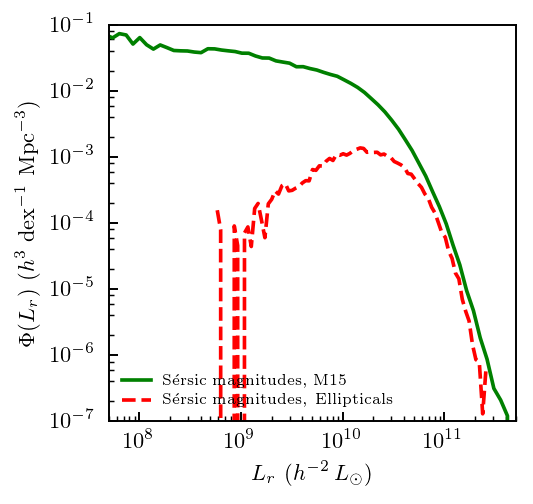

In [68]:
# plot LF
#
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^{-2}\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e11); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**aLbinc, aphi_Lbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\full\, M15}$')


plt.plot(10.**Lbinc, phi_Lbsmeert, '--', c='r', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ Ellipticals}$')




plt.legend(loc='lower left', fontsize=6, frameon=False)


plt.show()

## S0 Galaxies

In [69]:
# code to compute luminosity function of the SDSS galaxies in the SDSS catalog

from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.0
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];




#Probabilities to find morphological types
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 

Pmorphlim = 0.7


# make some cuts to eliminate bad regimes or catastrophic failures
ilim = ((vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sdata['z'] < z_max) & 
        (sb50 > 0.) & (sb50 <= 23.5) & (grm>-0.5) & (grm<2.2) & (pS0>Pmorphlim) & (pS0>pEll) & (pS0>pSab) & (pS0>pScd))
# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]

# extract quantities useful for LF computation
zm = sdata['z']; 
# Petrosian magnitude from SDSS pipeline
mpetrom = phot_r['petroMag']; 
# apparent magnitude calculated by the UPenn group using Sersic profile fit 
# to light surface brightness profile and better estimate of the background light
mmeert = mdata['m_tot']
# r-band extinction and k-correction (latter provided in the catalog in this case)
extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']


print "selected", np.size(zm), " after all cuts..."

# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); 
Lpetrom = 0.4*(4.67-Mpetrom)

# maximum d_M distance to which each galaxy can be detected by the survey
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# compute 1/d_M^3
vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93

# solid angle of the sample; 
# use 0.195 as a fraction of the sky covered by the sample, as reported by Meert et al. (2015)
solid_anglem = 0.195 * 4.*np.pi / 3
# compute final 1/Vmax for each galaxy
vmaxim = vmaxim / (solid_anglem*ccm)

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 20; nbins = 80 # use nboostrap resamplings and estimate LF using nbins bins
#first just get histogram without bootstrap to get bins 
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
# define bin centers and log widths
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

# compute mean LF over a specified number of bootstrap resamplings along with error
phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

# rescale LF and bins to dn/dlog10(L) in units of h^3 Mpc^-3 dex^-1
phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
Lbinc = np.log10(10.**Lbinc*cosmo.h**2) 

670722 galaxies in Meert et al. sample initially
selected 13880  after all cuts...


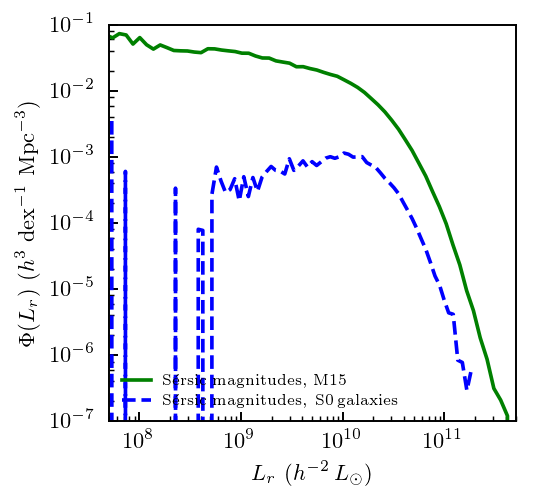

In [70]:
# plot LF
#
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^{-2}\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e11); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**aLbinc, aphi_Lbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\full\, M15}$')


plt.plot(10.**Lbinc, phi_Lbsmeert, '--', c='b', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ S0\, galaxies}$')




plt.legend(loc='lower left', fontsize=6, frameon=False)


plt.show()

## Sab galaxies


In [71]:
# code to compute luminosity function of the SDSS galaxies in the SDSS catalog

from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.0
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];




#Probabilities to find morphological types
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 

Pmorphlim = 0.7


# make some cuts to eliminate bad regimes or catastrophic failures
ilim = ((vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sdata['z'] < z_max) & 
        (sb50 > 0.) & (sb50 <= 23.5) & (grm>-0.5) & (grm<2.2) & (pSab>Pmorphlim) & (pSab>pEll) & (pSab>pS0) & (pSab>pScd))
# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]

# extract quantities useful for LF computation
zm = sdata['z']; 
# Petrosian magnitude from SDSS pipeline
mpetrom = phot_r['petroMag']; 
# apparent magnitude calculated by the UPenn group using Sersic profile fit 
# to light surface brightness profile and better estimate of the background light
mmeert = mdata['m_tot']
# r-band extinction and k-correction (latter provided in the catalog in this case)
extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']


print "selected", np.size(zm), " after all cuts..."

# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); 
Lpetrom = 0.4*(4.67-Mpetrom)

# maximum d_M distance to which each galaxy can be detected by the survey
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# compute 1/d_M^3
vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93

# solid angle of the sample; 
# use 0.195 as a fraction of the sky covered by the sample, as reported by Meert et al. (2015)
solid_anglem = 0.195 * 4.*np.pi / 3
# compute final 1/Vmax for each galaxy
vmaxim = vmaxim / (solid_anglem*ccm)

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 20; nbins = 80 # use nboostrap resamplings and estimate LF using nbins bins
#first just get histogram without bootstrap to get bins 
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
# define bin centers and log widths
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

# compute mean LF over a specified number of bootstrap resamplings along with error
phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

# rescale LF and bins to dn/dlog10(L) in units of h^3 Mpc^-3 dex^-1
phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
Lbinc = np.log10(10.**Lbinc*cosmo.h**2) 



670722 galaxies in Meert et al. sample initially
selected 19831  after all cuts...


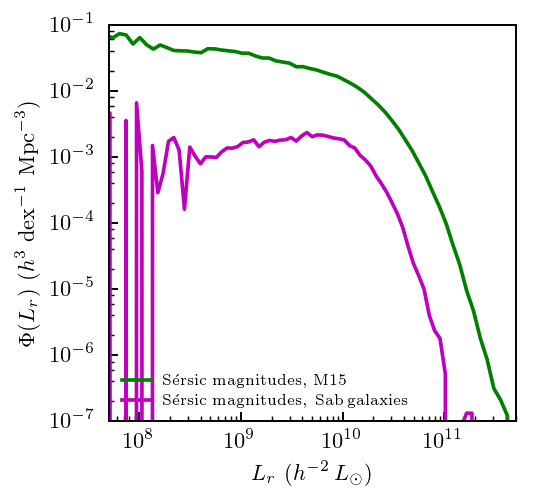

In [72]:
# plot LF
#
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^{-2}\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e11); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**aLbinc, aphi_Lbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\full\, M15}$')


plt.plot(10.**Lbinc, phi_Lbsmeert,  c='m', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ Sab\, galaxies}$')




plt.legend(loc='lower left', fontsize=6, frameon=False)


plt.show()

## Scd galaxies

In [73]:
# code to compute luminosity function of the SDSS galaxies in the SDSS catalog

from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.0
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];




#Probabilities to find morphological types
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 

Pmorphlim = 0.7


# make some cuts to eliminate bad regimes or catastrophic failures
ilim = ((vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sdata['z'] < z_max) & 
        (sb50 > 0.) & (sb50 <= 23.5) & (grm>-0.5) & (grm<2.2) & (pScd>Pmorphlim) &(pScd>pEll) & (pScd>pS0) & (pScd>pSab))

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]

# extract quantities useful for LF computation
zm = sdata['z']; 
# Petrosian magnitude from SDSS pipeline
mpetrom = phot_r['petroMag']; 
# apparent magnitude calculated by the UPenn group using Sersic profile fit 
# to light surface brightness profile and better estimate of the background light
mmeert = mdata['m_tot']
# r-band extinction and k-correction (latter provided in the catalog in this case)
extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']


print "selected", np.size(zm), " after all cuts..."

# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); 
Lpetrom = 0.4*(4.67-Mpetrom)

# maximum d_M distance to which each galaxy can be detected by the survey
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# compute 1/d_M^3
vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93

# solid angle of the sample; 
# use 0.195 as a fraction of the sky covered by the sample, as reported by Meert et al. (2015)
solid_anglem = 0.195 * 4.*np.pi / 3
# compute final 1/Vmax for each galaxy
vmaxim = vmaxim / (solid_anglem*ccm)

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 20; nbins = 80 # use nboostrap resamplings and estimate LF using nbins bins
#first just get histogram without bootstrap to get bins 
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
# define bin centers and log widths
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

# compute mean LF over a specified number of bootstrap resamplings along with error
phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

# rescale LF and bins to dn/dlog10(L) in units of h^3 Mpc^-3 dex^-1
phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
Lbinc = np.log10(10.**Lbinc*cosmo.h**2) 



670722 galaxies in Meert et al. sample initially
selected 17101  after all cuts...


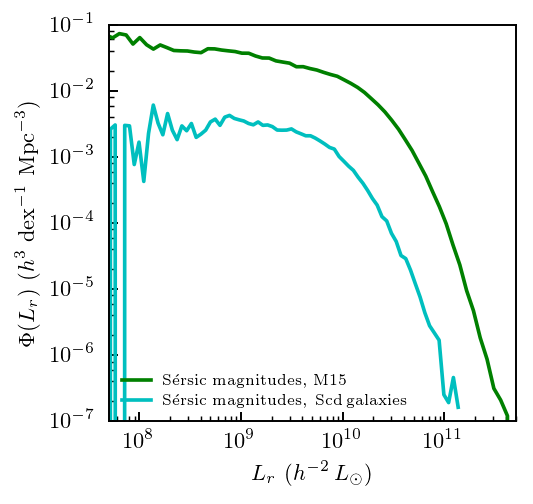

In [74]:
# plot LF
#
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^{-2}\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e11); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**aLbinc, aphi_Lbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\full\, M15}$')


plt.plot(10.**Lbinc, phi_Lbsmeert,  c='c', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ Scd\, galaxies}$')




plt.legend(loc='lower left', fontsize=6, frameon=False)


plt.show()

### Problem 2 - Stellar mass function of bright galaxies

Construct the stellar mass function -- analogue of luminosity function but were stellar mass is used instead of luminosities - for galaxies from the UPenn photometry catalog. Use the same Meert et al. catalog the way it was used to compute the luminosity function, but now convert $r$-band luminosities to stellar masses using galaxy $g-r$ color and construct stellar mass function: i.e., number density of galaxies as a function of stellar mass. To convert luminosities to stellar mass use stellar mass-to-light ratio calibrated using stellar population models by Bell et al. (2003): $\log_{10}(M_\star/L_r) = -0.306 + 1.097(g-r) - 0.1$, where $M_\star$ is in solar masses ($M_\odot$), $L_r$ is in $L_{\odot,r}$ and $-0.1$ corrects their calibration to a more conventional initial  mass function of stars (IMF). You can see how well this relation fits actual stellar population synthesis calculations in the <tt>ex03</tt> notebook in the repository.  



### Solution

In [75]:

# code to compute luminosity function of the SDSS galaxies in the SDSS catalog

from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)



# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.0
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];



# make some cuts to eliminate bad regimes or catastrophic failures
ilim = ((vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sdata['z'] < z_max) & 
        (sb50 > 0.) & (sb50 <= 23.5) & (grm>-0.5) & (grm<2.2))
# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]



# extract quantities useful for LF computation
zm = sdata['z']; 
# Petrosian magnitude from SDSS pipeline
mpetrom = phot_r['petroMag']; 
# apparent magnitude calculated by the UPenn group using Sersic profile fit 
# to light surface brightness profile and better estimate of the background light
mmeert = mdata['m_tot']
# r-band extinction and k-correction (latter provided in the catalog in this case)
extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

print "selected", np.size(zm), " after all cuts..."

# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); 
Lpetrom = 0.4*(4.67-Mpetrom)


#define masses, equivalently to the above definition luminosities
exponent = -0.306 +1.097*(grm)-0.1
M_Lmeert = Lmeert+exponent
M_Lpetrom = Lpetrom+exponent



# maximum d_M distance to which each galaxy can be detected by the survey
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# compute 1/d_M^3
vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93

# solid angle of the sample; 
# use 0.195 as a fraction of the sky covered by the sample, as reported by Meert et al. (2015)
solid_anglem = 0.195 * 4.*np.pi / 3
# compute final 1/Vmax for each galaxy
vmaxim = vmaxim / (solid_anglem*ccm)

# compute mass functions function for all galaxies and bootstrap errors
nbootstrap = 5; nbins = 40 # use nboostrap resamplings and estimate LF using nbins bins
#first just get histogram without bootstrap to get bins 
Mphi_Lmeert, MLbins = np.histogram(M_Lmeert, weights=vmaxim, bins=nbins)
# define bin centers and log widths
MLbinc = 0.5 * (MLbins[1:] + MLbins[:-1]); MdLbins = (MLbins[1:]-MLbins[:-1])

# compute mean MF over a specified number of bootstrap resamplings along with error
Mphi_Lbsmeert, Mephi_Lbsmeert = compute_lf_bootstrap(M_Lmeert, vmaxim, MLbins, nbootstrap)

# rescale LF and bins to dn/dlog10(L) in units of h^3 Mpc^-3 dex^-1
Mphi_Lbsmeert = Mphi_Lbsmeert  / MdLbins / cosmo.h**3
Mephi_Lbsmeert = Mephi_Lbsmeert  / MdLbins / cosmo.h**3
MLbinc = np.log10(10.**MLbinc*cosmo.h**2)

mertMphi = np.copy(Mphi_Lbsmeert)
mertMephi = np.copy(Mephi_Lbsmeert)
mertMLbinc = np.copy(MLbinc)


670722 galaxies in Meert et al. sample initially
selected 244854  after all cuts...


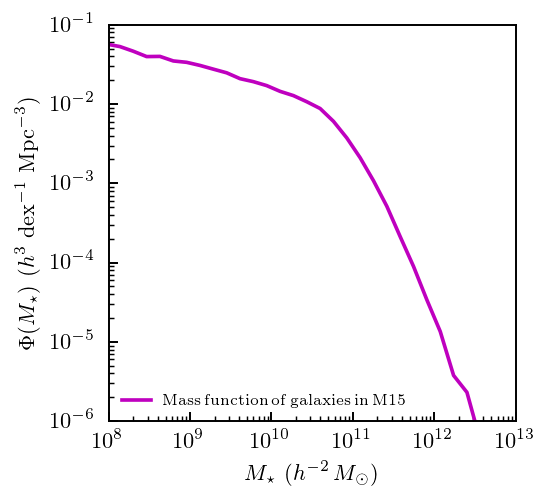

In [76]:
#
# plot LF
#
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M_\star\ (h^{-2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M_\star)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(1e8, 1e13); plt.ylim(1e-6, 1e-1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**MLbinc, Mphi_Lbsmeert, c='m', label=r'$\mathrm{Mass \, function\, of \, galaxies\, in\, M15}$')



plt.legend(loc='lower left', fontsize=6, frameon=False)


plt.show()

We see that the stellar mass function has the characteristic power-law shape, followed by an exponential cutoff.

### Problem 3 - Stellar mass function of low-luminosity galaxies

Use the <a href="http://www.gama-survey.org/dr2/">GAMA galaxy DR2 survey catalog</a> The fits file <tt>GAMA_DR2_master.fits</tt> is in the data/ subdirectory in the usual site.  Estimate stellar mass function of galaxies for the GAMA survey. The code snippet below shows you how to read the relevant data. 
Estimate of stellar mass is available in the GAMA catalog itself for each galaxy and its 10-base logarithm is given by variable <tt>logmstar</tt>.
This catalog probes relatively nearby universe ($z<0.06$) and its spectroscopic sample is deeper than SDSS by about two magnitudes. The apparent magnitude limit of the survey in the $r$ band is $m_{r,\rm lim}=19.4$ - i.e., almost 2 magnitudes deeper than SDSS. Thus it is more suitable for measuring luminosity and stellar mass function at faint luminosities (so-called "dwarf" galaxies). You can read more about the survey and measurements of stellar mass function for its galaxies in <a href="">Baldry et al. (2012)</a>. The code snippet below applies the same cuts to define the sample as in that study. The total survey area for the data in the file is 144 square degrees and it is 98% complete for $m_r\leq 19.4$ (7 points).

Compare the stellar mass function from GAMA to that you get from the Meert et al. photometry for the SDSS. Construct composite stellar mass function from the Meert et al. (2015) catalog (better at bright luminosities) and from the GAMA survey (better at the faint end) by taking the maximum of the two at each luminosity bin. Be careful to use the same units and h-scalings for both UPenn and GAMA stellar mass functions (3 points). We will be using the composite stellar mass function you construct later in the course to quantify relation between galaxy stellar mass and mass of its parent dark matter-dominated halo and to test galaxy formation model we will build. 

### Solution

In [77]:
# read GAMA data
#
import numpy as np
from colossus.cosmology import cosmology
from code.setup import data_home_dir

def read_GAMA(fname):
    import pyfits
    hdulist = pyfits.open(fname)
    return np.asarray(hdulist[1].data)
    
data = read_GAMA(data_home_dir()+"GAMA_DR2_full.fits")
print "read %d GAMA galaxies"%np.size(data['Z_HELIO'])

# these are conservative cuts in redshift and in magnitude
z_min = 0.001; z_max = 0.06
m_min = 10.5; m_max = 19.4

mpetro = data['PETROMAG_R']-data['EXTINCTION_R']
mg = data['GAL_MAG_G']; mi = data['GAL_MAG_I']; 
# apply magnitude and quality cuts
data = data[ (mpetro < m_max) & (mpetro > m_min) & (mg>1.) & (mg<25.) & (mi>1.) & (mi<25.)]; 
data = data[data['Z_TONRY'] > z_min];   
data = data[data['Z_TONRY'] < z_max]
data = data[data['NQ'] >= 2]
mpetro = data['PETROMAG_R']-data['EXTINCTION_R']
mg = data['GAL_MAG_G']; mi = data['GAL_MAG_I']; 
print("%d galaxies left after cuts"%np.size(data))

# log10(M*)
lMstar = data['logmstar']
Mstar = np.power(10.,lMstar)
zg = data['Z_HELIO']
zm = data['Z_TONRY']


# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')
d_Lm = cosmo.luminosityDistance(zg)/cosmo.h

Mpetro = mpetro - 5.0*np.log10(d_Lm/1e-5)  + 1.3*zm 

# fill in computation of stellar mass function for the GAMA survey here




read 71474 GAMA galaxies
4709 galaxies left after cuts


In [78]:
# maximum d_M distance to which each galaxy can be detected by the survey
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetro))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetro))/(1.+zm)

# compute 1/d_M^3
vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.98

# solid angle of the sample; 
# use 0.195 as a fraction of the sky covered by the sample, as reported by Meert et al. (2015)
solid_anglem = (144*(np.pi/180.0)**2.0)/3.0
# compute final 1/Vmax for each galaxy
vmaxim = vmaxim / (solid_anglem*ccm)






# compute mass functions function for all galaxies and bootstrap errors
nbootstrap = 5; nbins = 40 # use nboostrap resamplings and estimate LF using nbins bins
#first just get histogram without bootstrap to get bins 
Mphi_Lmeert, MLbins = np.histogram(lMstar, weights=vmaxim, bins=nbins)
# define bin centers and log widths
MLbinc = 0.5 * (MLbins[1:] + MLbins[:-1]); MdLbins = (MLbins[1:]-MLbins[:-1])

# compute mean MF over a specified number of bootstrap resamplings along with error
Mphi_Lbsmeert, Mephi_Lbsmeert = compute_lf_bootstrap(lMstar, vmaxim, MLbins, nbootstrap)

# rescale LF and bins to dn/dlog10(L) in units of h^3 Mpc^-3 dex^-1
Mphi_Lbsmeert = Mphi_Lbsmeert  / MdLbins / cosmo.h**3
Mephi_Lbsmeert = Mephi_Lbsmeert  / MdLbins / cosmo.h**3
MLbinc = np.log10(10.**MLbinc*cosmo.h**2)





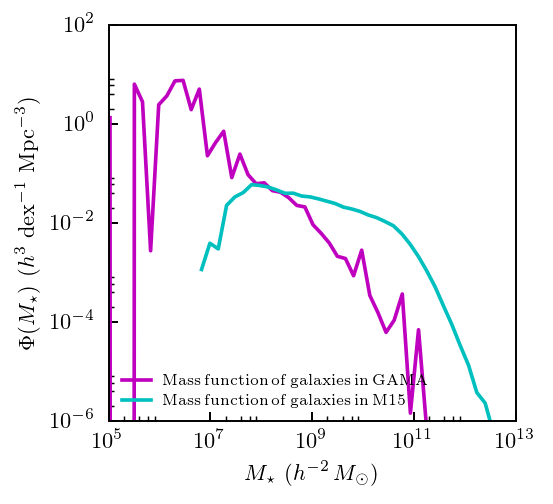

In [79]:
# plot LF
#
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M_\star\ (h^{-2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M_\star)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(1e5, 1e13); plt.ylim(1e-6, 1e+2)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**MLbinc, Mphi_Lbsmeert, c='m', label=r'$\mathrm{Mass \, function\, of \, galaxies\, in\, GAMA}$')
plt.plot(10.**mertMLbinc, mertMphi, c='c', label=r'$\mathrm{Mass \, function\, of \, galaxies\, in\, M15}$')




plt.legend(loc='lower left', fontsize=6, frameon=False)


plt.show()



#### Above we can see the two mass functions, for galaxies in GAMMA and in Meert catalogues

We will try to calculate the composite mass funtion


In [80]:
from scipy import interpolate

intergama = interpolate.splrep(MLbinc, Mphi_Lbsmeert, s=0)
intermeert = interpolate.splrep(mertMLbinc, mertMphi, s=0)

Lbincomp = np.zeros(80)
Mcompos = np.zeros(80)

Lbincomp = np.sort(np.concatenate((MLbinc, mertMLbinc)))

for i in range (0,80):
    if (Lbincomp[i] <= 7.0):
        for j in range (0,40):
            if (MLbinc[j] == Lbincomp[i]):
                Mcompos[i] = Mphi_Lbsmeert[j]
    elif (Mcompos[i] >= 9.0):
        for k in range (0,40):
             if (mertMLbinc[k] == Lbincomp[i]):
                Mcompos[i] = mertMphi[k]
    else:
        if (interpolate.splev(Lbincomp[i], intergama, der=0) >= interpolate.splev(Lbincomp[i], intermeert, der=0)):
            Mcompos[i] = interpolate.splev(Lbincomp[i], intergama, der=0)
        else:
            Mcompos[i] = interpolate.splev(Lbincomp[i], intermeert, der=0)
        
        
            
            
    





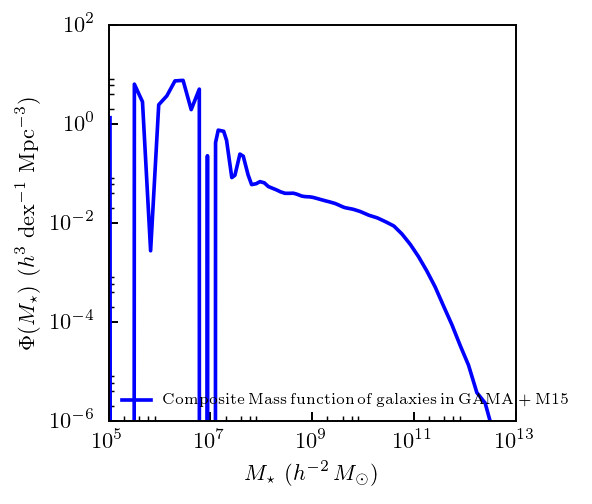

In [81]:
# plot LF
#
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M_\star\ (h^{-2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M_\star)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(1e5, 1e13); plt.ylim(1e-6, 1e+2)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Lbincomp, Mcompos, c='b', label=r'$\mathrm{Composite \,Mass \, function\, of \, galaxies\, in\, GAMA+M15}$')
#plt.plot(10.**mertMLbinc, mertMphi, c='c', label=r'$\mathrm{Mass \, function\, of \, galaxies\, in\, M15}$')




plt.legend(loc='lower left', fontsize=6, frameon=False)


plt.show()



Comparing with the previous two mass functions, we see that is indeed the composite mass function. Let us plot the three of them.

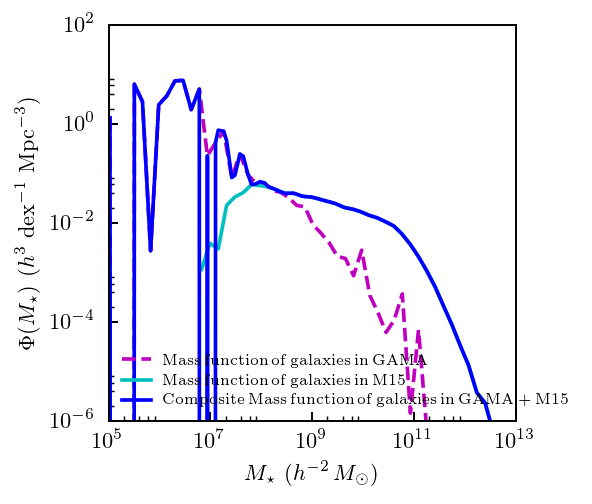

In [82]:
# plot LF
#
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M_\star\ (h^{-2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M_\star)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(1e5, 1e13); plt.ylim(1e-6, 1e+2)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**MLbinc, Mphi_Lbsmeert, '--', c='m', label=r'$\mathrm{Mass \, function\, of \, galaxies\, in\, GAMA}$')
plt.plot(10.**mertMLbinc, mertMphi, c='c', label=r'$\mathrm{Mass \, function\, of \, galaxies\, in\, M15}$')
plt.plot(10.**Lbincomp, Mcompos, c='b', label=r'$\mathrm{Composite \,Mass \, function\, of \, galaxies\, in\, GAMA+M15}$')



plt.legend(loc='lower left', fontsize=6, frameon=False)


plt.show()

